In [1]:
import numpy as np
import glob
import gymnasium as gym

from pynktrombonegymnasium.environment import PynkTrombone
from stable_baselines3.common.env_checker import check_env

/home/sandeepnmenon/miniconda/envs/rl_proj/lib/python3.10/site-packages/librosa/util/files.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [2]:
target_sound_files = glob.glob("./data/sample_target_sounds/*.wav")
target_sound_files

['./data/sample_target_sounds/correct_letter_A.wav']

In [3]:
from pynktrombonegymnasium.spaces import ActionSpaceNames as ASN
class ActionWrapper(gym.ActionWrapper):
    def _init_(self, env):
        super().__init__(env)
        self.action_space = env.action_space
        
    def action(self, action):
        mapped_actions = {}
        if isinstance(action, dict):
            mapped_actions = action
        elif isinstance(action, (np.ndarray,list)):
            for i, key in enumerate(sorted(self.dict_action_space.spaces.keys())):
                mapped_actions[key] = action[i]
        else:
            raise ValueError(f"Unexpected action type: {type(action)}")
        
        return {
            ASN.PITCH_SHIFT: mapped_actions[ASN.PITCH_SHIFT],
            ASN.TENSENESS: (mapped_actions[ASN.TENSENESS] + 1) * 0.5,
            ASN.TRACHEA: (mapped_actions[ASN.TRACHEA] + 1) * 1.75,
            ASN.EPIGLOTTIS: (mapped_actions[ASN.EPIGLOTTIS] + 1) * 1.75,
            ASN.VELUM: (mapped_actions[ASN.VELUM] + 1)* 1.75,
            ASN.TONGUE_INDEX: (mapped_actions[ASN.TONGUE_INDEX]+1)*28+12,
            ASN.TONGUE_DIAMETER: (mapped_actions[ASN.TONGUE_DIAMETER]+1)*1.75,
            ASN.LIPS: (mapped_actions[ASN.LIPS]+1)*0.75
        }
                
    
    
def make_env(target_sound_files):
    env = PynkTrombone(target_sound_files)
    env2 = ActionWrapper(env)
    return env2

We detected your env to be a GoalEnv because `env.compute_reward()` was defined.
If it's not the case, please rename `env.compute_reward()` to something else to avoid False positives.


/home/sandeepnmenon/miniconda/envs/rl_proj/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation achieved_goal has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/home/sandeepnmenon/miniconda/envs/rl_proj/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation desired_goal has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


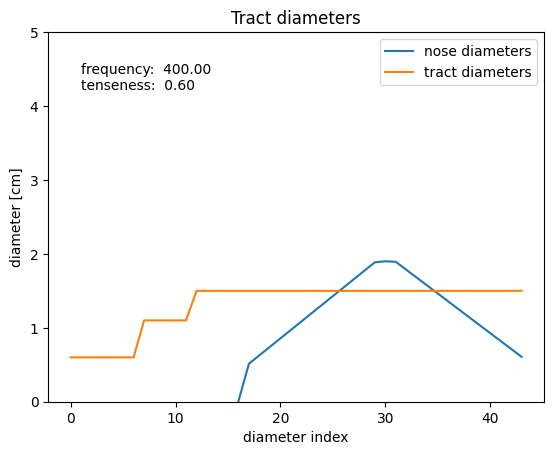

In [4]:
SAMPLE_RATE = 44100
env = PynkTrombone(target_sound_files=target_sound_files, sample_rate=SAMPLE_RATE)
check_env(env, warn=True)

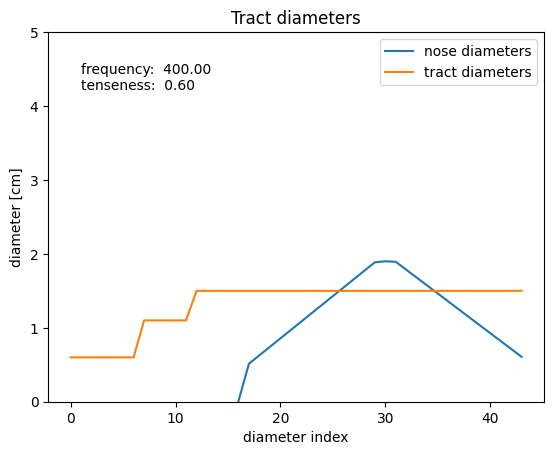

In [5]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_vec_env
from functools import partial

# Instantiate the env

vec_env = make_vec_env(PynkTrombone, n_envs=1, env_kwargs=dict(target_sound_files=target_sound_files, sample_rate=SAMPLE_RATE))

In [6]:
from sb3_plus import MultiOutputPPO
from stable_baselines3.common.type_aliases import Schedule

def linear_schedule(initial_value: float) -> Schedule:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

model = MultiOutputPPO(
    policy='MultiInputPolicy',
    env=vec_env,
    learning_rate = linear_schedule(initial_value=2e-2),
    batch_size=512,
    verbose=0,
    policy_kwargs=dict(
        net_arch=dict(pi=[128] * 4, vf=[128] * 4)
    ),
    tensorboard_log="./logs/mimo_pynktrombone_tensorboard/"
)

In [7]:
from stable_baselines3.common.callbacks import CheckpointCallback

# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path="./logs/",
  name_prefix="rl_model_whisper",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

In [8]:
model.learn(
    total_timesteps=int(300000),
    progress_bar=True,
    tb_log_name="mi_ppo_pynk_whisper",
    callback=checkpoint_callback
)


Output()

: 

In [ ]:
# model.save("mimo_ppo_pynktrombone_1")
model.save("mi_ppo_pynktrombone_whisper")



In [ ]:
target_sound_files

['./data/sample_target_sounds/correct_letter_A.wav']

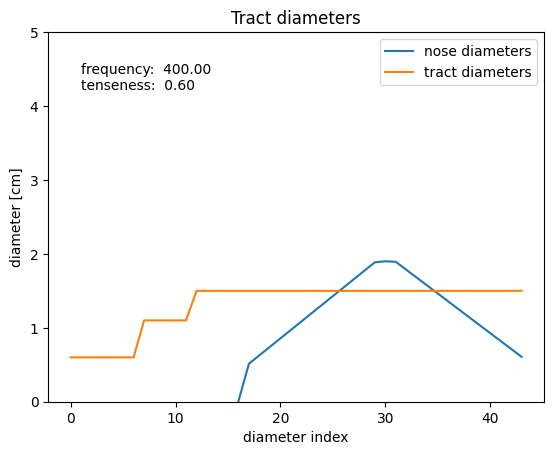

In [ ]:
import glob

from pynktrombonegymnasium.environment import PynkTrombone
from stable_baselines3.common.env_util import make_vec_env
from sb3_plus import MultiOutputPPO

target_sound_files = glob.glob("./data/sample_target_sounds/*.wav")

# Instantiate the env
SAMPLE_RATE = 44100
vec_env = make_vec_env(PynkTrombone, n_envs=1, env_kwargs=dict(target_sound_files=target_sound_files, sample_rate=SAMPLE_RATE))
model = MultiOutputPPO.load("logs/rl_model_500000_steps", env=vec_env)


In [ ]:
target_sound_files

['./data/sample_target_sounds/correct_letter_A.wav']

In [ ]:
import numpy as np
import os
from typing import Callable

import soundfile
from pynktrombonegymnasium.spaces import ObservationSpaceNames as OSN
from pynktrombonegymnasium.wrappers import ActionByAcceleration, Log1pMelSpectrogram

output_dir = "submodules/PynkTromboneGymnasium/data/test_results_mimoppo_pynktrombone"
file_name = "generated_from_mi_model_5.wav"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
generated_waves = []
obs = vec_env.reset()
dones = [False]
while True:
    if dones[0]:
        break

    action, _states = model.predict(obs)
    print(action)
    obs, rewards, dones, info = vec_env.step(action)  # type: ignore
    generated_sound_wave = obs[OSN.GENERATED_SOUND_WAVE]

    generated_waves.append(generated_sound_wave[0])

generated_sound_wave = np.concatenate(generated_waves).astype(np.float32)

path = os.path.join(output_dir, file_name)
soundfile.write(path, generated_sound_wave, vec_env.envs[0].env.sample_rate)

[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]
[[ 1. -1. -1.  1.  1. -1.  1.  1.]]


In [ ]:
vec_env[0].

(216, 1024)

---------------------------------------------------------------------------------------------